This is an analysis of Los Angeles Crime Data. 

Dataset source:
https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq

Hope to show some insights from the data including:

    -What type of crime is most prevalent?
    -What type of crime is least prevalent?
    -Where was there more crime? Show on Map
    -Where was there less crime? Show on Map
    -Where did most batteries occured? Show on Map
    -When did crimes occured? Show on Plot
    -Is crime increasing or decreasing in time? Show on Plot
    -Show crime by area_name

In [20]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import numpy as np
from pandas import datetime
from folium.plugins import MarkerCluster
from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline

In [2]:
csv = '/Users/nonoumasy/Downloads/data/LA_Crime_Data_from_2010_to_Present.csv'
df = pd.read_csv(csv)

In [3]:
#clean the data
df = df[['Date Occurred','Time Occurred', 'Area Name', 'Crime Code',
         'Crime Code Description','Weapon Description', 'Address',
        'Location ']]

#replace blankspace with underscore
df.columns = df.columns.str.replace(' ', '_')  

#changes column names to lowercase
df.columns = df.columns.str.lower()  

In [4]:
#take out the "()"
df['location_'] = df['location_'].str.replace("(", "").str.replace(")", "")

#convert str to float
df['location_'] = (df['location_'].str.split(',').apply(lambda lst: [float(x.strip()) for x in lst]))

In [135]:
#cleanup time_occurred column
df.time_occurred = df.time_occurred.astype(str)
df.time_occurred = df.time_occurred.map(lambda a : a[:-2] + ":" + a[-2:] )

In [136]:
#convert to datetime format
df.date_occurred = df.date_occurred.apply(pd.to_datetime)

In [86]:
#map weekday to weekday name
df['weekday_name'] = df.date_occurred.dt.weekday_name

In [155]:
df.head()

,date_occurred,time_occurred,area_name,crime_code,crime_code_description,weapon_description,address,location_,weekday_name
0,2015-01-16,2130,Van Nuys,510,VEHICLE - STOLEN,NaN,6200 FULTON AV,"[34.1814, -118.4263]",Friday
1,2015-01-01,230,Southeast,626,INTIMATE PARTNER - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",200 E 97TH ST,"[33.9483, -118.2717]",Thursday
2,2015-10-01,800,77th Street,805,PIMPING,NaN,FIGUEROA ST,"[33.9807, -118.2827]",Thursday
3,2015-01-01,40,Central,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),NaN,HILL ST,"[34.0591, -118.2412]",Thursday
4,2015-01-01,240,Central,626,INTIMATE PARTNER - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",500 W 7TH ST,"[34.0467, -118.2556]",Thursday


In [36]:
#what type of crime is most prevalent?
df.crime_code_description.value_counts()[:5]

BATTERY - SIMPLE ASSAULT              172969
BURGLARY FROM VEHICLE                 146743
VEHICLE - STOLEN                      145721
BURGLARY                              135867
THEFT PLAIN - PETTY ($950 & UNDER)    135333
Name: crime_code_description, dtype: int64

In [38]:
#what type of crime is least prevalent?
df.crime_code_description.value_counts()[-5:]

TILL TAP - ATTEMPT                          3
BLOCKING DOOR INDUCTION CENTER              3
FIREARMS RESTRAINING ORDER (FIREARMS RO)    2
TRAIN WRECKING                              2
DRUNK ROLL - ATTEMPT                        1
Name: crime_code_description, dtype: int64

In [61]:
#where was there most crime?
df.area_name.value_counts()[:5]

77th Street    131722
Southwest      122674
N Hollywood    103320
Pacific        100906
Southeast      100288
Name: area_name, dtype: int64

In [62]:
#where was there least crime?
df.area_name.value_counts()[-5:]

Rampart       80521
West LA       80127
Wilshire      78481
Foothill      72360
Hollenbeck    70000
Name: area_name, dtype: int64

In [102]:
#Where did most BATTERY - SIMPLE ASSAULT occured?
df[df.crime_code_description == 'BATTERY - SIMPLE ASSAULT'].area_name.value_counts()[:]

77th Street    13978
Central        12978
Southwest      12957
Southeast      10503
Olympic        10006
Hollywood       9520
Newton          9043
Rampart         8593
Mission         8244
N Hollywood     7728
Pacific         7457
Hollenbeck      7316
Van Nuys        6741
Northeast       6697
Wilshire        6342
Harbor          6315
Topanga         6199
West LA         6007
Devonshire      5845
West Valley     5405
Foothill        5095
Name: area_name, dtype: int64

#map of LAPD Divisional Map
![Image of Yaktocat](http://www.lapdwilshire.com/uploads/3/0/7/1/30711601/6222770.jpg?816)

In [162]:
df.location_.apply(lambda x : folium.CircleMarker(location=[x[0],x[1]]).add_to(mc))

0    34.1814
1    33.9483
2    33.9807
3    34.0591
4    34.0467
Name: location_, dtype: float64

In [190]:
df.shape

(1906525, 9)

In [191]:
#map of crime in LA
m = folium.Map(location=[34, -118], tiles='stamentoner', zoom_start=11)
mc = MarkerCluster().add_to(m)

df.location_[0:500].apply(lambda x : folium.CircleMarker(location=[x[0],x[1]], fill=True, color='red').add_to(mc))
m.save('/Users/nonoumasy/Desktop/crime_map.html')
m


In [150]:
#When did most crimes occured in terms of days of the week?
df.weekday_name.value_counts().sort_index()

Friday       293485
Monday       271685
Saturday     274028
Sunday       262138
Thursday     268350
Tuesday      266788
Wednesday    270051
Name: date_occurred, dtype: int64

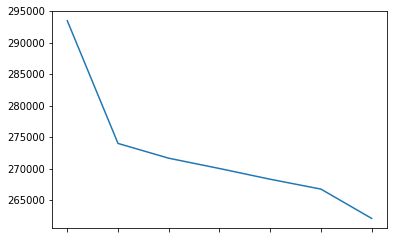

In [141]:
#When did most crimes occured in terms of days of the week?
df.weekday_name.value_counts().plot()

In [81]:
#When did crimes occured in terms of specific days?
df.date_occurred.value_counts()[0:5]

2010-01-01    2196
2011-01-01    2117
2012-01-01    1728
2013-01-01    1557
2014-01-01    1421
Name: date_occurred, dtype: int64

In [83]:
#When did crimes occured in terms of a weekday?
df.date_occurred.dt.weekday.value_counts()[0:5]

4    293485
5    274028
0    271685
2    270051
3    268350
Name: date_occurred, dtype: int64

In [131]:
#Is crime increasing or decreasing in time?
df.date_occurred.dt.year.value_counts().sort_index()[0:9]

2010    208753
2011    200384
2012    201094
2013    192128
2014    194903
2015    214686
2016    224445
2017    229531
2018    224745
Name: date_occurred, dtype: int64

Text(0.5, 1.0, 'Is Crime going up or down in the city of Angels?')

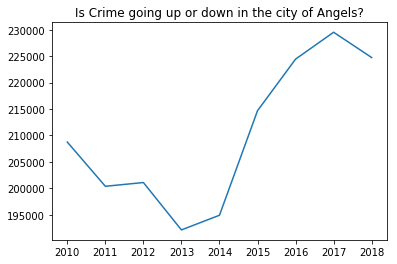

In [139]:
#Show if crime is increasing or decreasing in time
df.date_occurred.dt.year.value_counts().sort_index()[0:9].plot()
plt.title('Is Crime going up or down in the city of Angels?')